# DATASETS & DATALOADERS

处理数据样本的代码可能是凌乱的以至于难以维护。我们非常希望我们数据库的代码与我们模型训练的代码分开，让代码有更好的易读性和模块性。Pytorch提供了两个data primitives 一个是<kbd>torch.utils.data.DataLoader</kbd>另一个是<kbd>torch.utils.data.Dataset</kbd>允许你使用pre-loaded的dataset或者加载你自己的data。Dataset保存着samples以及它们的corresponding label，DataLoader封装了关于Dataset的迭代器让我们可以轻易地取访问这些samples。

Pytorch的domain libraries提供了大量的pre-loaded datasets(例如FashionMNIST)，子类<kbd>torch.utils.data.Dataset</kbd>以及针对与特定数据的实现函数。它们可以用于prototype和benchmark你的model。你可以在**Image Datasets**, **Text Datasets**, and **Audio Datasets**中找到它们。

## Loading a Dataset

这是一个如何从TorchVision加载FashionMNIST dataset的例子。FashionMNIST数据集是一个Zalando文章图片的dataset包含60000张的training examples和10000张的test examples。每个example是一张28x28的grayscale image和其对应的label（总共十个类别）。

我们加载FashionMNIST Dataset需要如下的参数

* **root**：train/test data保存的路径 
* **train**：指定training dataset还是test dataset 
* **download=True**：从互联网下载数据，除非root指定的路径不可用
* **transform**和**target_transform**指定feature和label的变换(transformation)。

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


E:\Software\Anaconda3\envs\py38\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 迭代并可视化Dataset

我们使用training_data[index]访问图片数据。使用matplotlib库对抽取出来的图片进行可视化。

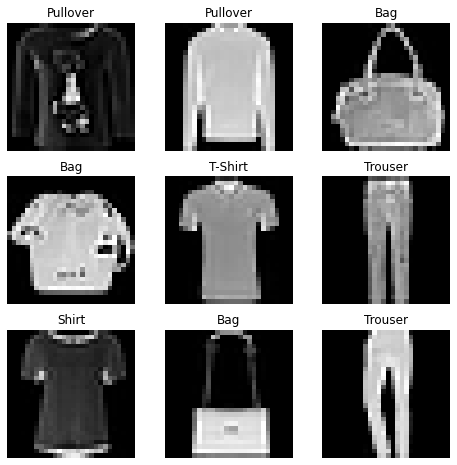

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure=plt.figure(figsize=(8,8))
cols,rows=3,3
for i in range(1,cols*rows+1):
    sample_idx=torch.randint(len(training_data),size=(1,)).item()
    img,label=training_data[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(),cmap="gray")

plt.show()

## 创建一个自定义的Dataset

一个自定义的Dataset必须实现三个函数：<kbd>\_\_init\_\_</kbd>,<kbd>\_\_len\_\_</kbd>和<kbd>\_\_getitem\_\_</kbd>。我们关注一下这个函数的实现；FashionMNIST图像存储在<kbd>img_dir</kbd>路径下,他们的labels分开存储在CSV文件<kbd>annotations_file</kbd>中。在下一节中我们将依次分析每个函数。

In [4]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### \_\_init\_\_

\_\_init\_\_函数当Dataset object对象被实例化时运行一次。我们初始化的的路径包含images和annotations file以及两个变换(transforms).

labels.csv文件看起来像这样：

tshirt1.jpg, 0

tshirt2.jpg, 0

......

ankleboot999.jpg, 9

\_\_init\_\_部分代码：
```python

def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
```

### \_\_len\_\_

\_\_len\_\_函数返回我们dataset中的sample的数量

例子：

```python
def __len__(self):
    return len(self.img_labels)

```

### \_\_getitem\_\_
\_\_getitem\_\_函数加载并返回dataset中给定索引idx位置上的sample。依据索引识别出image在disk上的位置，并通过<kbd>read_image</kbd>将image转换为一个tensor。在<kbd>self.img_labels</kbd>的csv数据里找到对应的label，调用transform函数(if applicable),然后返回tensor化的image和它对应的label到一个tuple中。

```python
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label
```

## 通过DataLoader准备你的training data
<kbd>Dataset</kbd>每次检索我们Dataset的feature和label一个sample。当训练一个model时。我们往往会将sample放入一个minibatch中，然后每一次的Epoch都会重洗data，来防止model的overfitting，使用python的multiprocessing来加速data的retrieval。

<kbd>DataLoader</kbd>是可迭代的使用了一个简单的API隐藏(abstract)了它的复杂性。


In [5]:
from torch.utils.data import DataLoader
train_dataloader=DataLoader(training_data,batch_size=64,shuffle=True)
test_dataloader=DataLoader(test_data,batch_size=64,shuffle=True)


## 通过DataLoader迭代数据

我们将dataset加载到了<kbd>DataLoader</kbd>中,并可以根据需要迭代我们的dataset。每一次的迭代都会返回一批train_features和train_labels(包含batch_size=64个feature和label)。因为我们指定了shuffle=True，当我们每次迭代完所有的batch后，数据都会被重洗。

Feature batch shape:torch.Size([64, 1, 28, 28])
Labels batch shape:torch.Size([64])


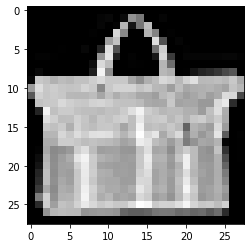

Label:8


In [8]:
# Display image and label
train_features,train_labels=next(iter(train_dataloader))
print(f"Feature batch shape:{train_features.size()}")
print(f"Labels batch shape:{train_labels.size()}")
img = train_features[0].squeeze()
label=train_labels[0]
plt.imshow(img,cmap="gray")
plt.show()
print(f"Label:{label}")

## 拓展阅读:
[torch.utils.data API](https://pytorch.org/docs/stable/data.html)